In [1]:
%load_ext autoreload
%autoreload 2

import cv2
import json
import os
import shutil
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm

from tools.coco_formatter import COCOFormatter
from tools.demo import Predictor
from yolox.exp import get_exp
from yolox.data.datasets import COCO_CLASSES
from yolox.utils import postprocess

### Moving image files

In [ ]:
if not os.path.exists("datasets/soccer/train2017"):
    os.mkdir("datasets/soccer/train2017")

if not os.path.exists("datasets/soccer/val2017"):
    os.mkdir("datasets/soccer/val2017")

if not os.path.exists("datasets/soccer/annotations"):
    os.mkdir("datasets/soccer/annotations")

In [17]:
def move_image_files(source="datasets/selectstar1", target="datasets/soccer/train2017"):
    image_files = [f for f in os.listdir(source) if f.endswith(".jpg")]
    for f in tqdm(image_files):
        shutil.move(f"{source}/{f}", f"{target}/{f}")

In [18]:
move_image_files(source="datasets/selectstar1", target="datasets/soccer/train2017")
move_image_files(source="datasets/selectstar2", target="datasets/soccer/train2017")
move_image_files(source="datasets/selectstar3", target="datasets/soccer/val2017")
# move_image_files(source="datasets/selectstar4", target="datasets/soccer/val2017")

100%|██████████| 500/500 [00:00<00:00, 41000.84it/s]


### Converting data to the COCO format

In [26]:
formatter = COCOFormatter("datasets/soccer/val2017")
formatter.append_txt("datasets/selectstar3", image_size=(2080, 3840))
# formatter.save_txt("datasets/soccer/annotations/instances_val2017.json")
len(formatter.image_list), len(formatter.label_list)

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:00<00:00, 6872.06it/s]


(500, 9784)

In [27]:
formatter.translate_bbox_labels(y=-80)
formatter.save_txt("datasets/soccer/annotations/instances_val2017.json")

In [30]:
formatter = COCOFormatter("datasets/soccer/train2017")
formatter.append_txt("datasets/selectstar1", image_size=(2080, 3840))
formatter.append_txt("datasets/selectstar2", image_size=(2080, 3840))
# formatter.save_txt("datasets/soccer/annotations/instances_train2017.json")
len(formatter.image_list), len(formatter.label_list)

100%|██████████| 5000/5000 [00:00<00:00, 5632.96it/s]


(10648, 191990)

In [18]:
formatter.translate_bbox_labels(y=-80)
formatter.save_txt("datasets/soccer/annotations/instances_train2017.json")

### Visualization

In [2]:
def plot_one_box(bbox: list, image: np.ndarray, color, label=None, line_thickness=None):
    # Plots one bounding box on image img
    tl = line_thickness or round(0.002 * (image.shape[0] + image.shape[1]) / 2) + 1  # line/font thickness
    
    c1, c2 = (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3]))
    cv2.rectangle(image, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)
    if label:
        tf = max(tl - 1, 1)  # font thickness
        t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(image, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(image, label, (c1[0], c1[1] - 2), 0, tl / 3, [255, 255, 255], thickness=tf, lineType=cv2.LINE_AA)

##### (1) Visualizing an image with true bounding boxes

In [3]:
split_dir = "train2017"
with open(f"datasets/soccer/annotations/instances_{split_dir}.json") as f:
    txt = json.load(f)

image_df = pd.DataFrame(txt["images"]).set_index("id")
label_df = pd.DataFrame(txt["annotations"]).set_index("id")
image_df

file_name  height  width
id                                       
0      video_01_000036.jpg    2080   3840
1      video_01_000037.jpg    2080   3840
2      video_01_000038.jpg    2080   3840
3      video_01_000039.jpg    2080   3840
4      video_01_000041.jpg    2080   3840
...                    ...     ...    ...
10643  video_33_000198.jpg    2080   3840
10644  video_33_000199.jpg    2080   3840
10645  video_33_000200.jpg    2080   3840
10646  video_33_000201.jpg    2080   3840
10647  video_33_000202.jpg    2080   3840

[10648 rows x 3 columns]

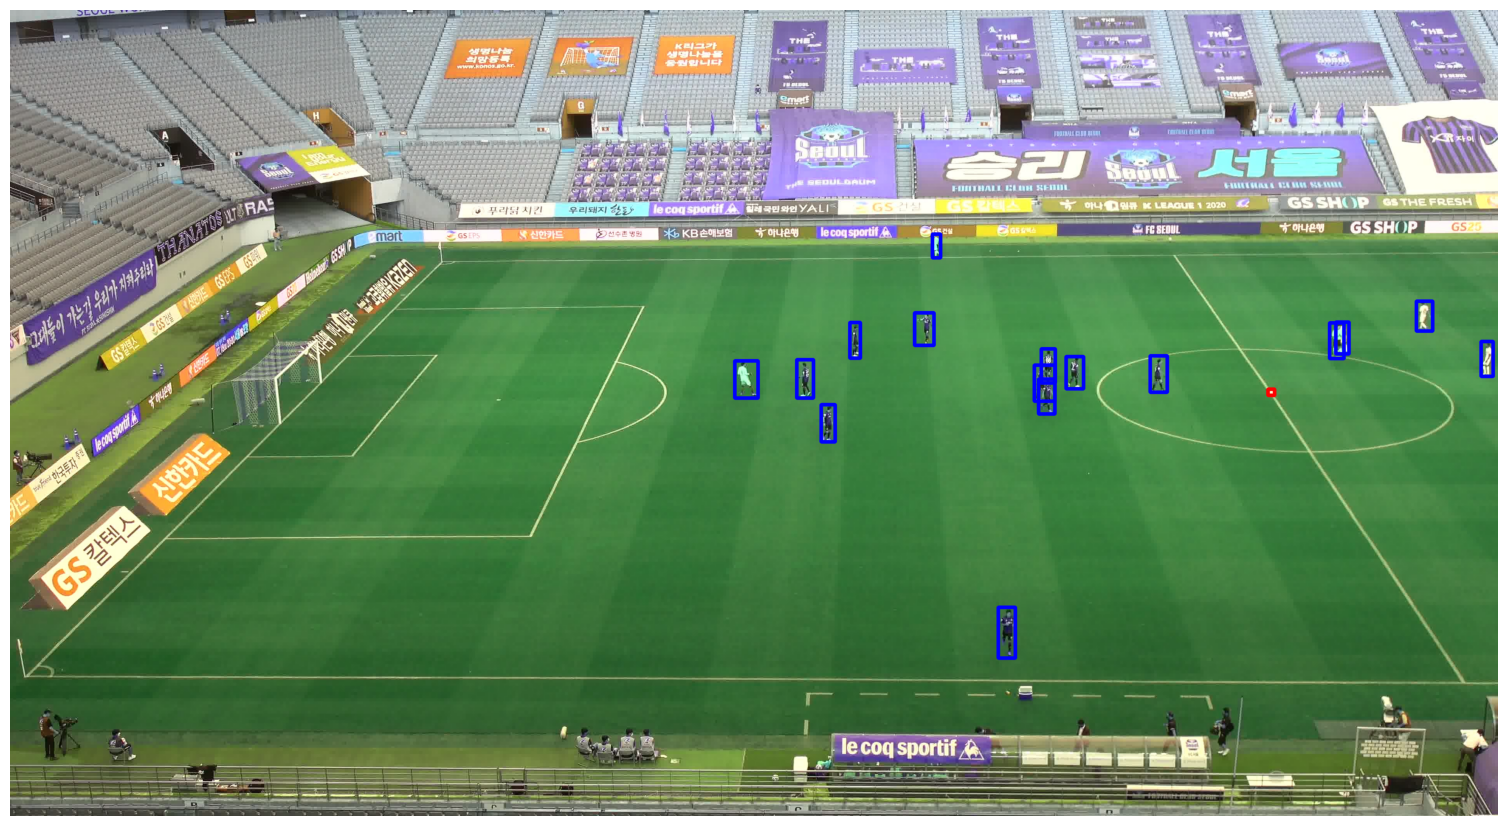

In [4]:
image_id = 0

image_file = image_df.at[image_id, "file_name"]
image = cv2.imread(f"datasets/soccer/{split_dir}/{image_file}")
image_labels = label_df[label_df["image_id"] == image_id]

colors = {1: [0, 0, 255], 37: [255, 0, 0]}
for i in image_labels.index:
    x, y, w, h = image_labels.at[i, "bbox"]
    bbox = x, y, x + w, y + h
    color = colors[image_labels.at[i, "category_id"]]
    plot_one_box(bbox, image, color)

plt.figure(figsize=(19.2, 10.8))
plt.imshow(image[::-1])
plt.axis("off")
plt.grid(False)

##### (2) Visualizing an image with predicted bounding boxes

In [11]:
model_name = "yolox_s"
exp_path = "exps/example/custom/yolox_s.py"
ckpt_path = "YOLOX_outputs/yolox_s/best_ckpt.pth"
image_path = "datasets/soccer/sample_image.jpg"
device = torch.device("mps") if torch.backends.mps.is_available() else "cpu"

exp = get_exp(exp_path, model_name)
ckpt = torch.load(ckpt_path, map_location="cpu", weights_only=False)

model = exp.get_model()
model.to(device)
model.half()
model.eval()
model.load_state_dict(ckpt["model"])

predictor = Predictor(model, exp, COCO_CLASSES, device=device)

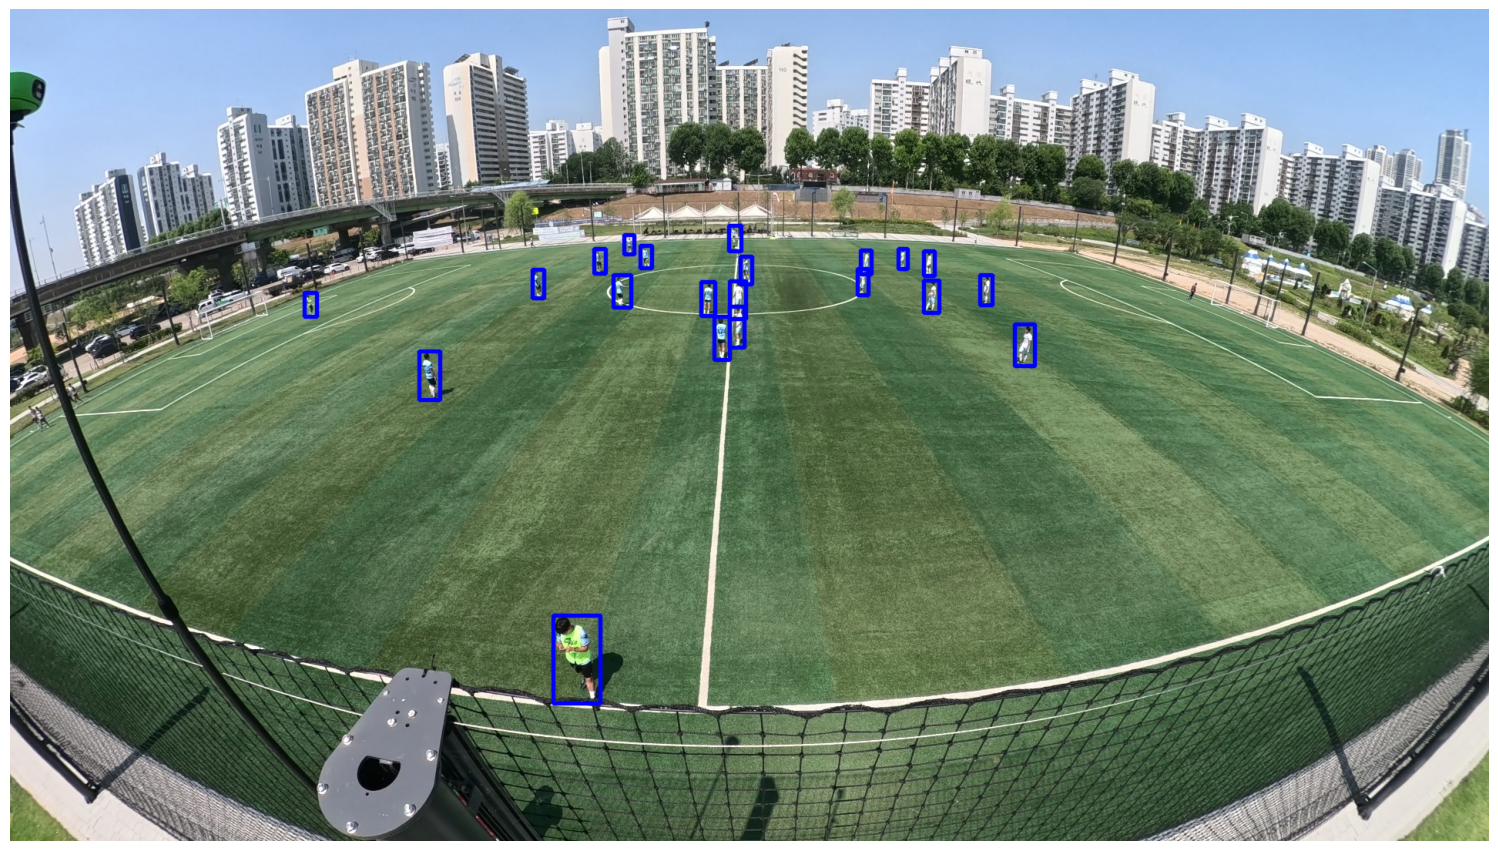

In [12]:
image = cv2.imread(image_path)
# outputs, img_info = predictor.inference(image)

padded_image = np.pad(image, ((0, 1000), (0, 1920), (0, 0))).transpose(2, 0, 1)
with torch.no_grad():
    outputs = model(torch.HalfTensor(padded_image).unsqueeze(0).to(device))
    outputs = postprocess(outputs, exp.num_classes, exp.test_conf, exp.nmsthre, class_agnostic=True)

colors = {0: [255, 0, 0], 32: [0, 0, 255]}
for i in range(outputs[0].shape[0]):
    if outputs[0][i, 4] * outputs[0][i, 5] < 0.5:
        continue
    bbox = outputs[0][i, :4].cpu().numpy()
    color = colors[int(outputs[0][i, -1].item())]
    plot_one_box(bbox, image, color)

plt.figure(figsize=(19.2, 10.8))
plt.imshow(image[:, :, ::-1])
plt.axis("off")
plt.grid(False)

In [5]:
bbox_cols = ["x1", "y1", "x2", "y2", "conf1", "conf2", "class"]
image_bboxes = pd.DataFrame(outputs[0].cpu().numpy(), columns=bbox_cols)
image_bboxes[bbox_cols[:4]] = image_bboxes[bbox_cols[:4]].round(2)
image_bboxes["conf"] = image_bboxes["conf1"] * image_bboxes["conf2"]
image_bboxes["class"] = image_bboxes["class"].map({0: "player", 32: "ball"})
image_bboxes = image_bboxes[bbox_cols[:4] + ["conf", "class"]]
image_bboxes.to_csv("YOLOX_outputs/yolox_s/bboxes/sample_image.csv")
image_bboxes

x1      y1           x2      y2      conf   class
0   1186.00  352.00  1206.000000  394.00  0.867105  player
1   1304.00  409.75  1330.000000  463.25  0.860775  player
2    783.00  345.50   806.000000  387.50  0.857207  player
3    531.50  444.50   558.500000  507.50  0.856423  player
4    897.00  354.25   915.000000  398.25  0.846537  player
5    948.00  321.00   963.000000  357.00  0.841101  player
6   1259.00  345.75  1275.000000  384.75  0.839792  player
7    678.00  338.75   693.000000  375.25  0.833038  player
8    914.50  399.75   934.500000  455.75  0.831896  player
9   1186.00  314.50  1200.000000  346.00  0.826578  player
10   818.00  307.50   833.000000  336.50  0.824655  player
11   758.00  311.00   773.000000  343.50  0.817022  player
12  1153.00  311.00  1165.000000  337.00  0.804691  player
13  1100.00  337.75  1114.000000  371.25  0.804339  player
14  1104.00  313.00  1118.000000  344.50  0.804096  player
15   934.50  386.00   953.500000  439.00  0.790715  player
16   934.50  353.25   955.500000  402.75  0.786541  player
17   382.00  368.25   398.500000  399.75  0.781109  player
18   797.00  293.75   810.000000  318.25  0.759610  player
19   705.00  787.50   766.000000  901.50  0.692686  player
20   933.50  281.75   949.500000  314.75  0.665806  player
21   939.00  303.50   951.000000  327.50  0.108629  player
22    20.27  512.00    54.380001  551.00  0.095950  player
23  1527.00  353.50  1543.000000  381.00  0.093883  player
24   791.00  378.50   798.000000  386.50  0.010103    ball

### Inference and visualization for a video

In [3]:
model_name = "yolox_s"
exp_path = "exps/example/custom/yolox_s.py"
ckpt_path = "YOLOX_outputs/yolox_s/best_ckpt.pth"
video_path = "datasets/soccer/videos/GX010224_Trim_18.07.mp4"
device = torch.device("mps") if torch.backends.mps.is_available() else "cpu"  # "cuda:0"
bbox_cols = ["x1", "y1", "x2", "y2", "conf1", "conf2", "class"]

exp = get_exp(exp_path, model_name)
ckpt = torch.load(ckpt_path, weights_only=False, map_location="cpu")

model = exp.get_model()
model.to(device)
model.half()
model.eval()
model.load_state_dict(ckpt["model"])

<All keys matched successfully>

In [4]:
def get_drop_frames(n_frames: int) -> Tuple[int, np.ndarray]:
    n_frames_total = (int(n_frames / 29.97) + 1) * 30
    minute_frames = np.arange(0, n_frames_total + 1, 1800)
    ten_minute_frames = np.arange(0, n_frames_total + 1, 18000)
    drop_frames = np.setdiff1d(minute_frames, ten_minute_frames)
    drop_frames = np.union1d(drop_frames, drop_frames + 1)
    return n_frames + len(drop_frames), drop_frames

In [5]:
video = cv2.VideoCapture(video_path)
n_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
n_frames, drop_frames = get_drop_frames(n_frames)

# video.set(cv2.CAP_PROP_POS_FRAMES, 0)
bbox_cols = ["x1", "y1", "x2", "y2", "conf1", "conf2", "class"]
bbox_list = []

for i in tqdm(np.setdiff1d(np.arange(1, n_frames), drop_frames)[:3000]):
    video.grab()
    if i % 30 != 0:
        continue

    ret, image = video.retrieve()
    if image is None:
        break

    padded_image = np.pad(image, ((0, 1000), (0, 1920), (0, 0))).transpose(2, 0, 1)
    with torch.no_grad():
        outputs = model(torch.HalfTensor(padded_image).unsqueeze(0).to(device))
        outputs = postprocess(outputs, exp.num_classes, exp.test_conf, exp.nmsthre, class_agnostic=True)

    image_bboxes = pd.DataFrame(outputs[0].cpu().numpy(), columns=bbox_cols)
    image_bboxes["frame"] = i
    bbox_list.append(image_bboxes)

bboxes = pd.concat(bbox_list, ignore_index=True)
bboxes[bbox_cols[:4]] = bboxes[bbox_cols[:4]].round(2)
bboxes["conf"] = bboxes["conf1"] * bboxes["conf2"]
bboxes["class"] = bboxes["class"].map({0: "player", 32: "ball"})
bboxes = bboxes[["frame"] + bbox_cols[:4] + ["conf", "class"]]
bboxes

100%|█████████▉| 1947/1950 [00:29<00:00, 65.44it/s]


frame      x1      y1      x2      y2      conf   class
0        30  1283.0  545.00  1345.0  642.00  0.897924  player
1        30  1249.0  334.75  1279.0  386.25  0.896306  player
2        30  1782.0  527.50  1818.0  585.50  0.889089  player
3        30   686.0  502.75   726.0  596.50  0.884297  player
4        30  1436.0  329.50  1460.0  374.00  0.875698  player
...     ...     ...     ...     ...     ...       ...     ...
3016   1920  1234.0  407.75  1244.0  416.75  0.055934    ball
3017   1920   941.5  332.25   950.5  340.25  0.035006    ball
3018   1920   940.0  330.75   950.0  338.75  0.019013    ball
3019   1920  1551.0  679.00  1569.0  697.00  0.016775    ball
3020   1920  1589.0  714.50  1603.0  727.50  0.010473    ball

[3021 rows x 7 columns]

In [31]:
os.makedirs("YOLOX_outputs/yolox_s/bboxes", exist_ok=True)
bboxes.to_csv("YOLOX_outputs/yolox_s/bboxes/sample_video.csv")